# Imports

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations, zip_longest
from glob import glob
from pathlib import Path

In [2]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator  # puts significance values on box-type plots

In [3]:
from skbio.stats.composition import clr, multiplicative_replacement

In [4]:
%matplotlib inline
sns.set(palette='muted', style='whitegrid', context='paper', font_scale=1.5)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves

## Plot function

In [5]:
def diff_plot(data: pd.DataFrame, x: str, n=20, ax=None) -> mpl.axes.Axes:
    """
        >>> diff_plot(log_fold_change_table, x_column, number_of_top_entries_to_show)
        generates a horizontal bar plot of differential abundance
    """
    if x not in data.columns:
        raise AttributeError(f'{x} not in DataFrame columns')
    cmap = mpl.cm.get_cmap('bwr') # Blue-white-red gradient
    data = data.sort_values(x)
    # generate a palette for each X value for it's relative position along the gradient
    data_max = data[x].max()
    data_min = data[x].min()
    xrange = data[x].apply(lambda n: abs(n)/data_max if n>=0 else abs(n)/data_min)
    xrange = (xrange+1.0)/2
    xpalette = dict(zip(xrange.index, xrange.apply(lambda x:cmap(x))))
    # get the top_N items and massage the data into the proper form
    if n < len(data):
        top_n = pd.concat([data[:int(n/2)], data[-int(n/2):]])
    else:
        top_n = data
    yname = top_n.index.name
    top_n = top_n.reset_index()
    if not yname or yname == 'index':
        top_n = top_n.rename({'index':'items'}, axis='columns')
        yname = 'items'
    
    # build the plot
    if not ax:
        ax = plt.gca()
    return sns.barplot(
        data=top_n,
        x=x,
        y=yname,
        palette=xpalette,
        ax = ax
    )

# LFC Tables

In [6]:
lfc_tables = sorted((Path(p) for p in glob('aldex2/*.csv')))

In [7]:
condition_order = [
    'BSH- VEHICLE',
    'BSH+ VEHICLE',
    'BSH- LETROZOLE',
    'BSH+ LETROZOLE',
]
condition_groups = list(
    combinations(condition_order,2)
)
condition_palette = {
    'BSH- VEHICLE': 'blue',
    'BSH+ VEHICLE': 'green',
    'BSH- LETROZOLE': 'orange',
    'BSH+ LETROZOLE': 'red',
}

family: BSH+ VEHICLE, BSH+ LETROZOLE
7


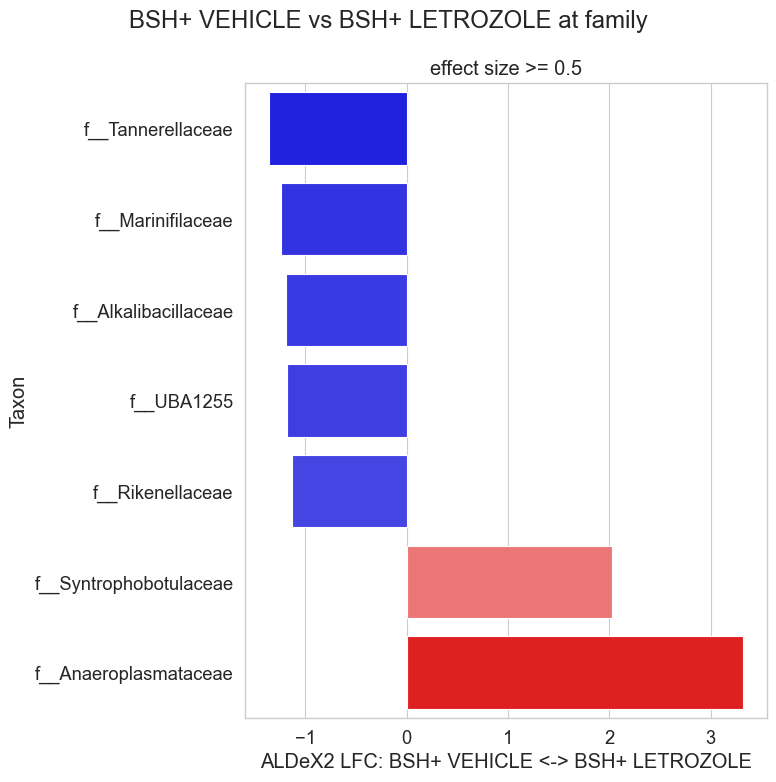

0
family: BSH- LETROZOLE, BSH+ LETROZOLE
0
0
family: BSH+ VEHICLE, BSH- LETROZOLE
21


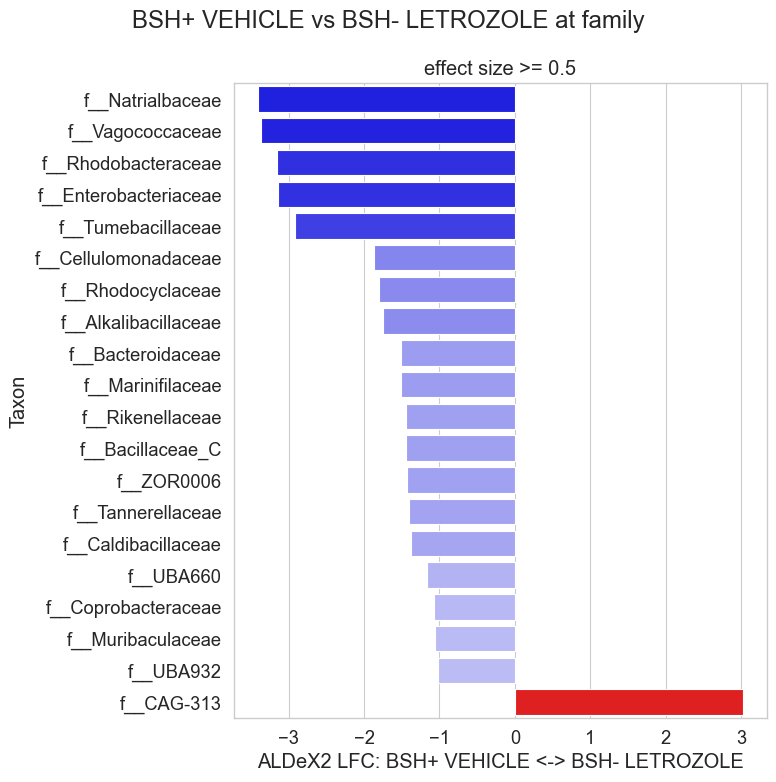

2


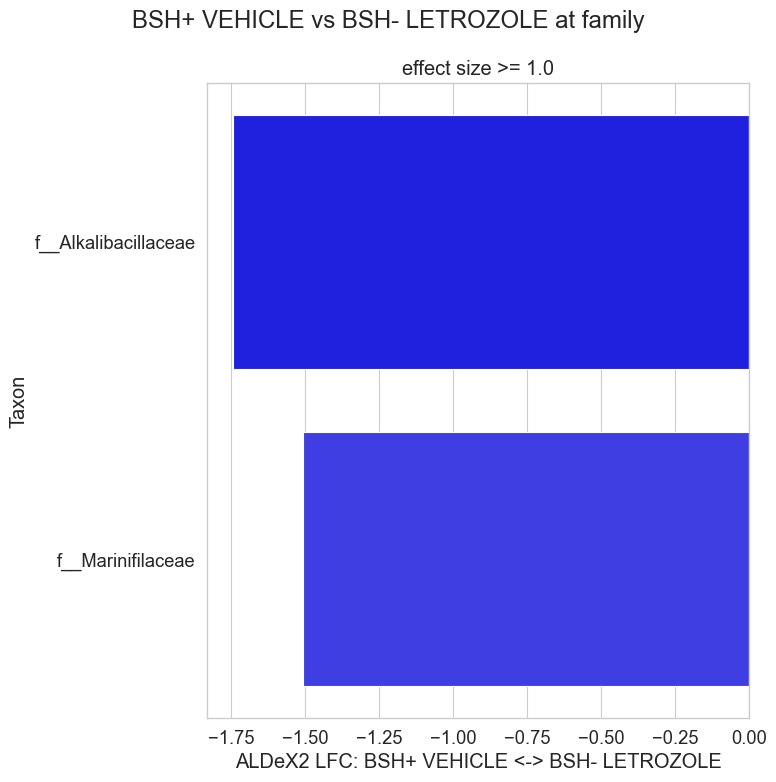

family: BSH- VEHICLE, BSH+ LETROZOLE
8


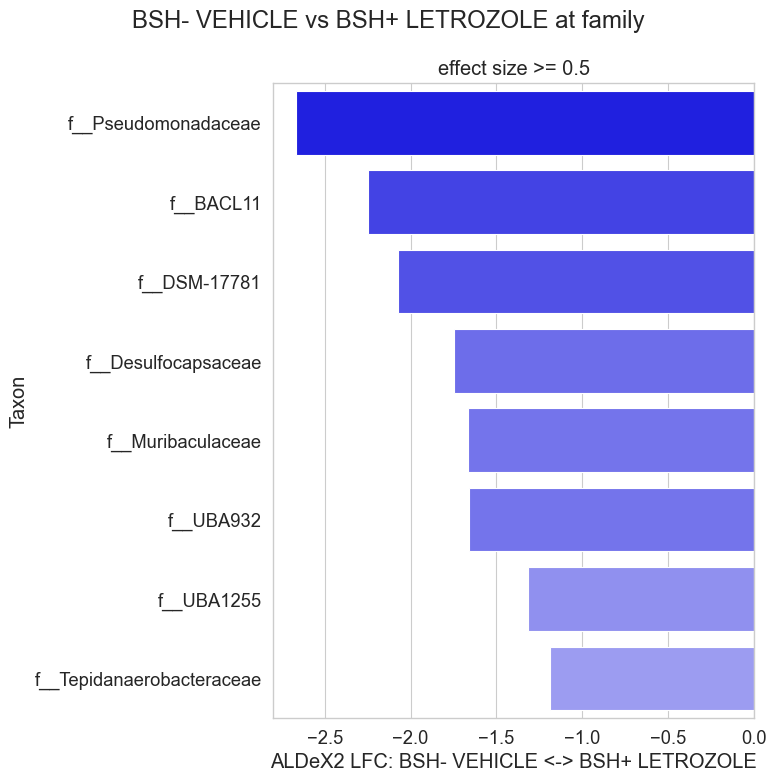

0
family: BSH- VEHICLE, BSH+ VEHICLE
7


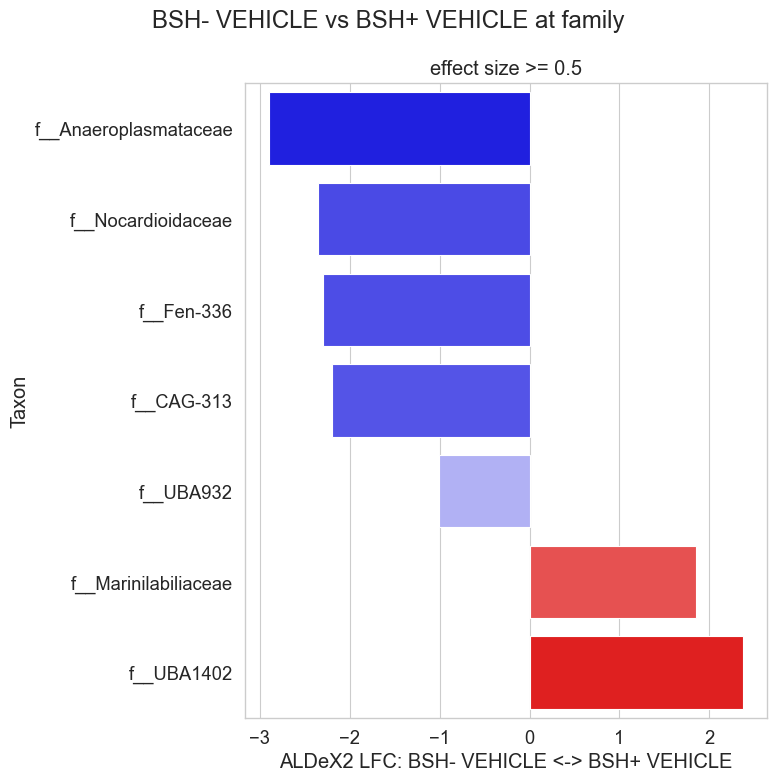

0
family: BSH- VEHICLE, BSH- LETROZOLE
15


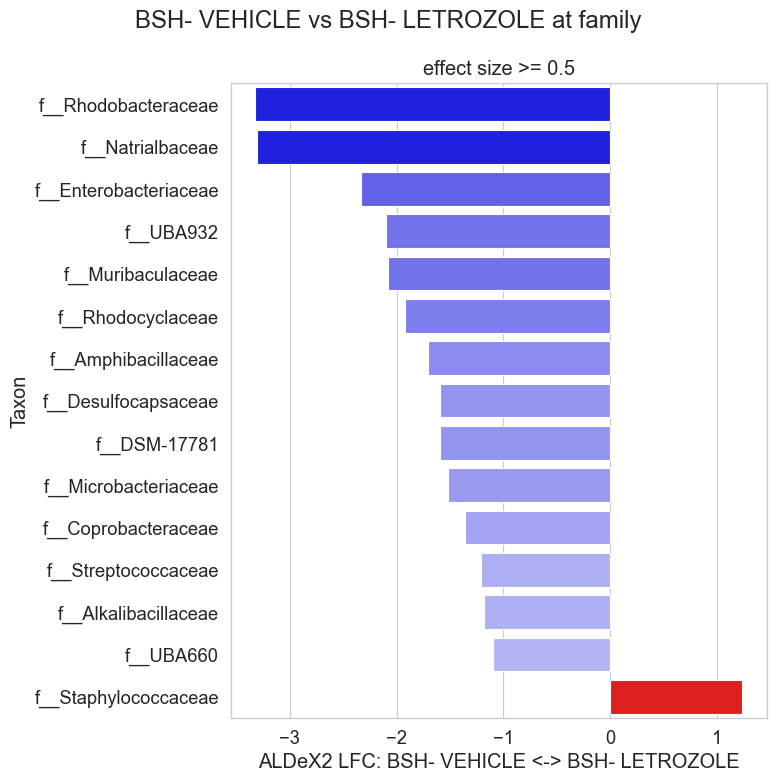

0
genus: BSH+ VEHICLE, BSH+ LETROZOLE
18


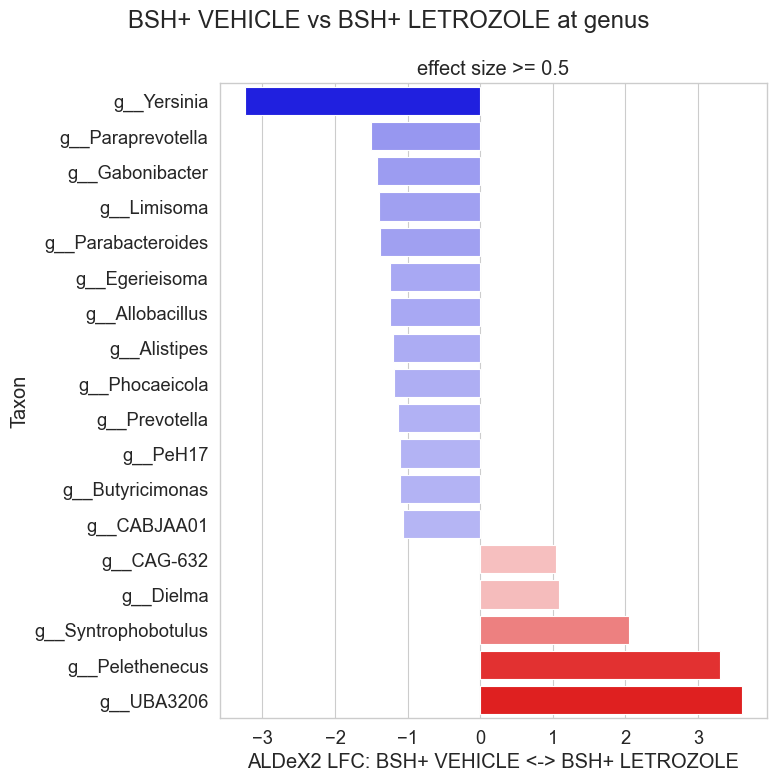

0
genus: BSH- LETROZOLE, BSH+ LETROZOLE
8


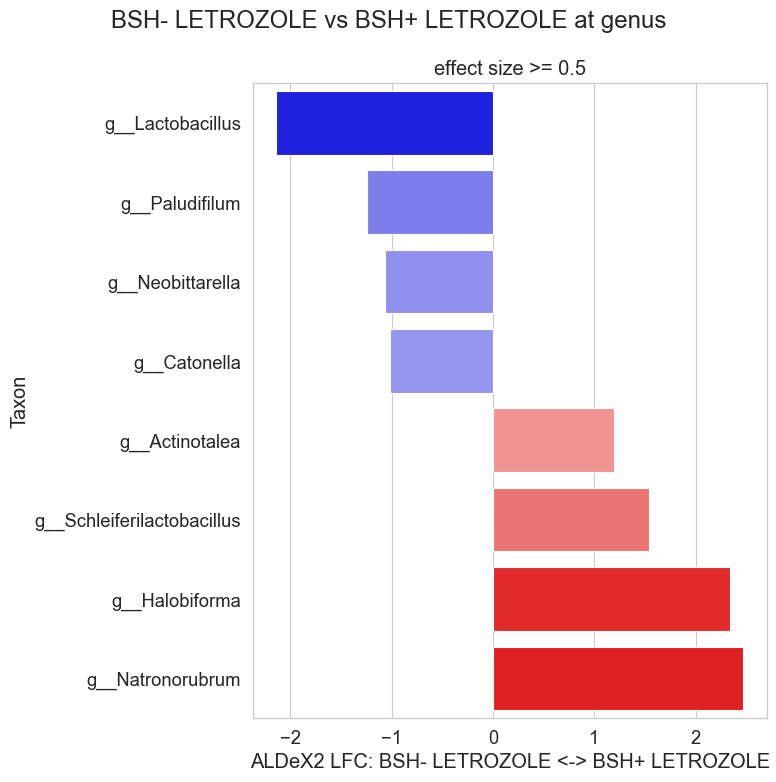

0
genus: BSH+ VEHICLE, BSH- LETROZOLE
53


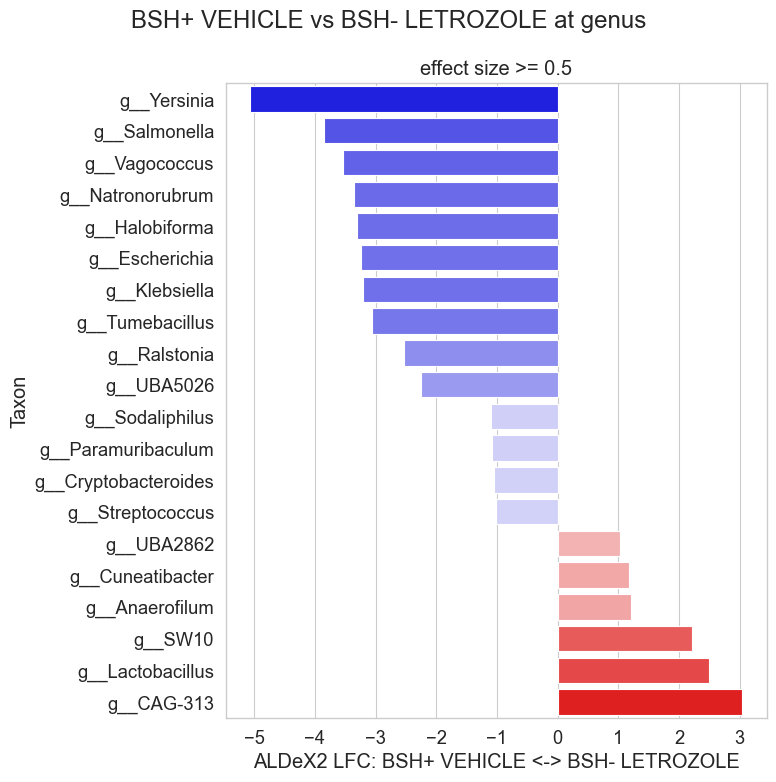

5


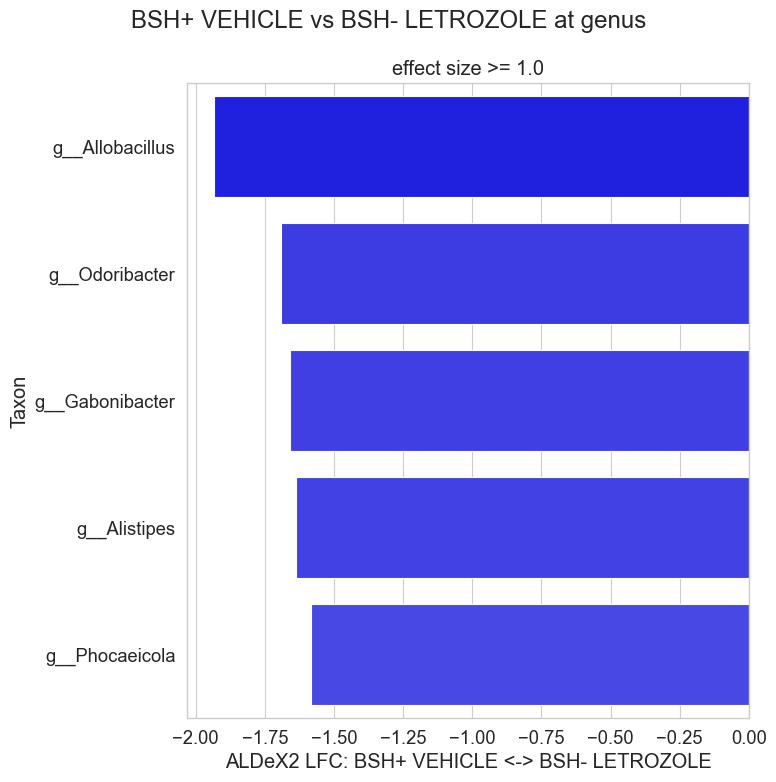

genus: BSH- VEHICLE, BSH+ LETROZOLE
18


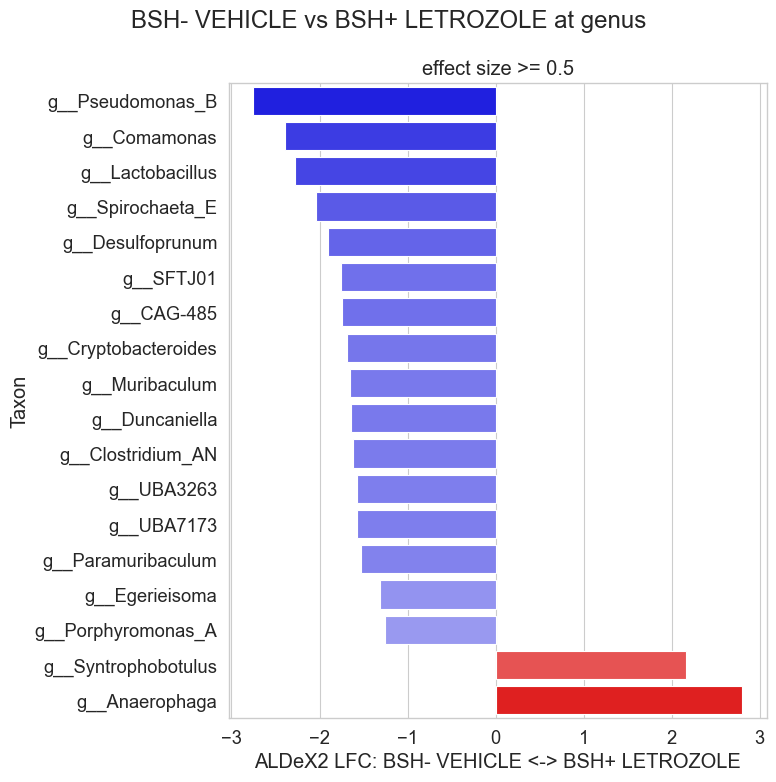

0
genus: BSH- VEHICLE, BSH+ VEHICLE
12


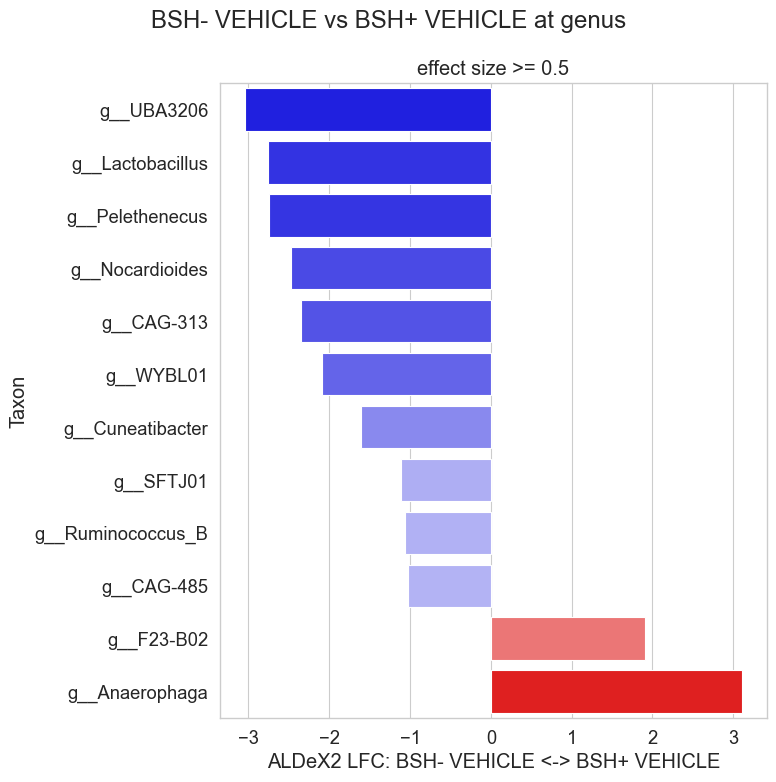

0
genus: BSH- VEHICLE, BSH- LETROZOLE
39


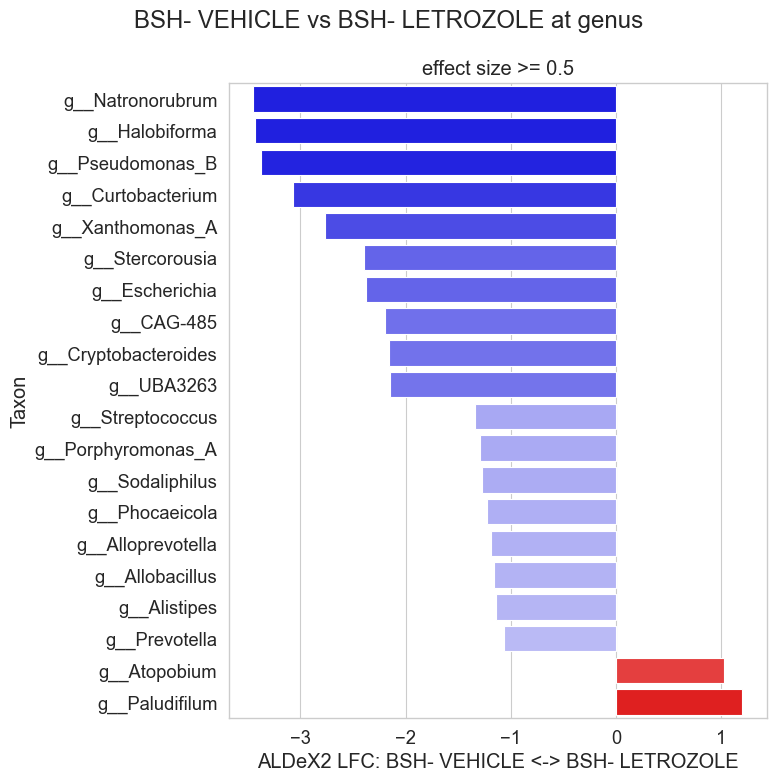

3


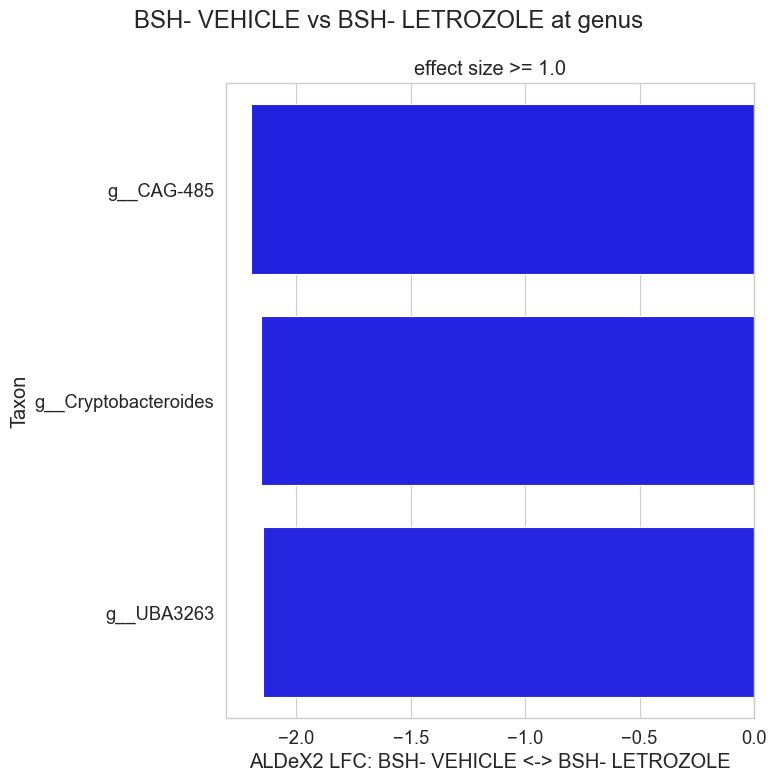

species: BSH+ VEHICLE, BSH+ LETROZOLE
45


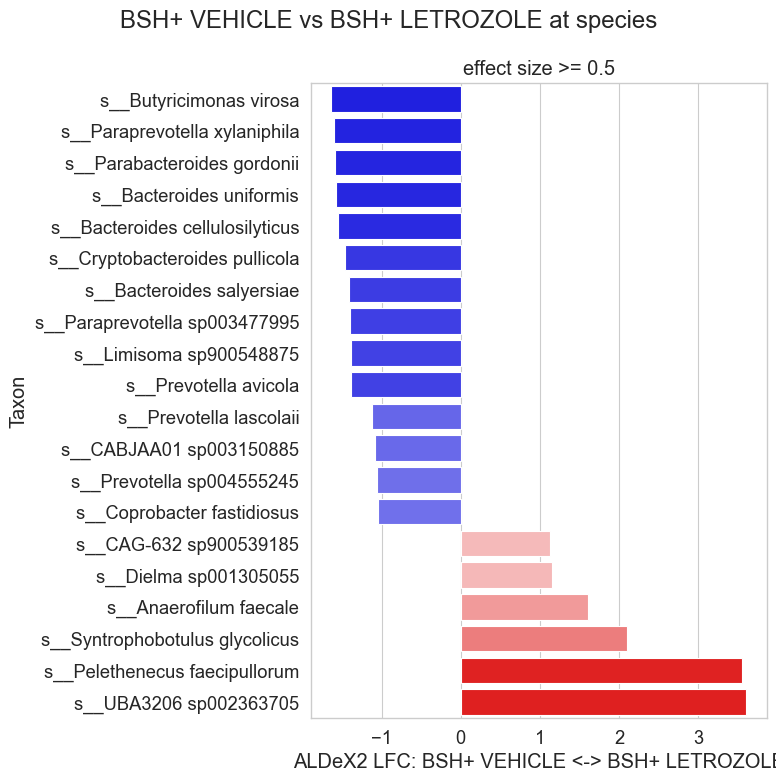

0
species: BSH- LETROZOLE, BSH+ LETROZOLE
17


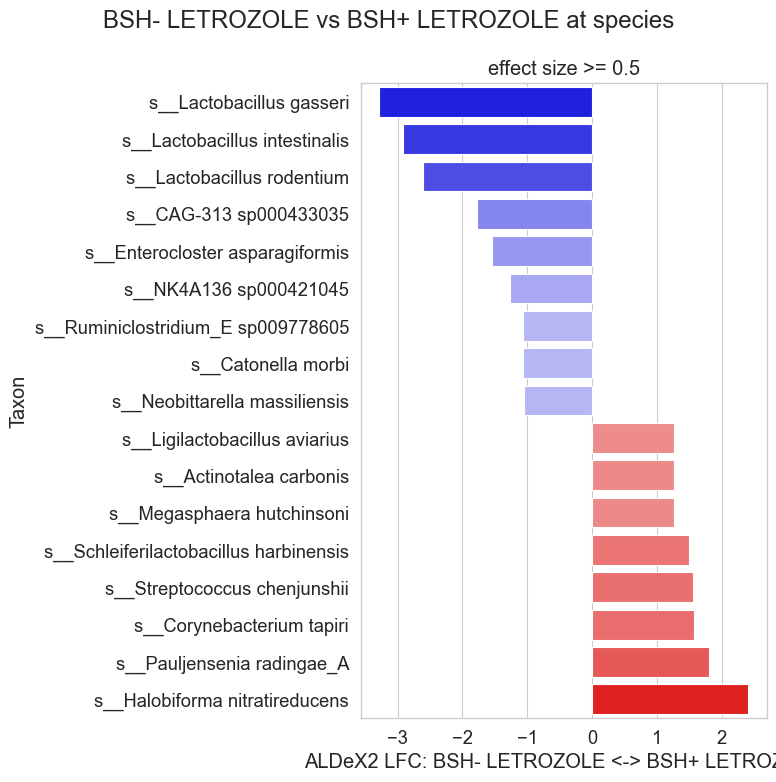

0
species: BSH+ VEHICLE, BSH- LETROZOLE
114


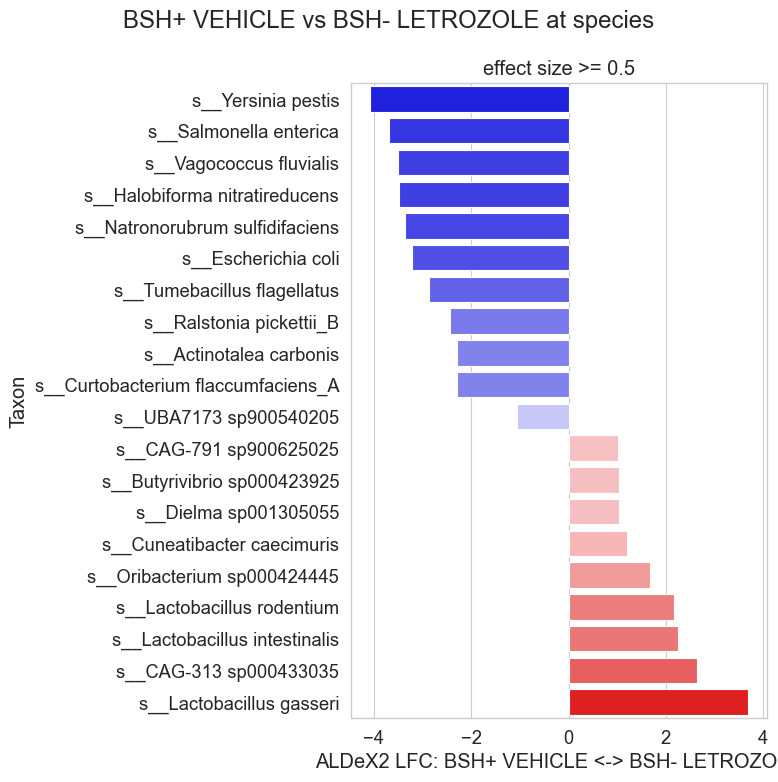

14


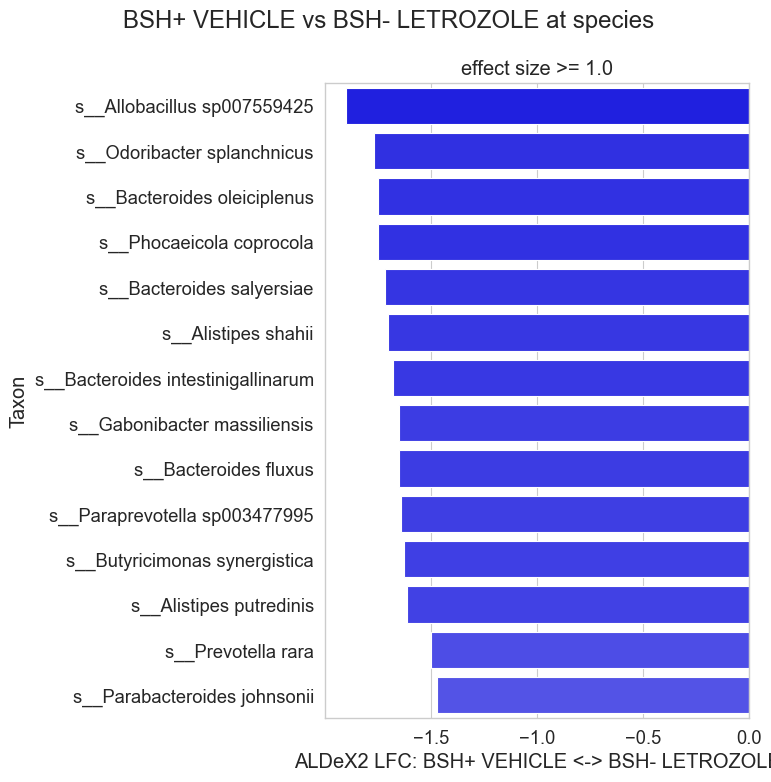

species: BSH- VEHICLE, BSH+ LETROZOLE
38


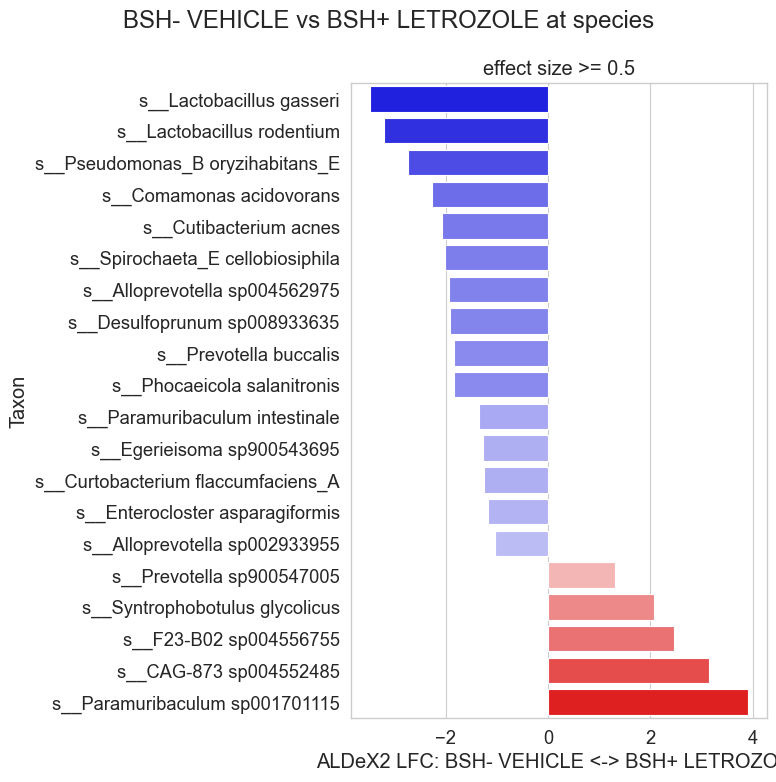

0
species: BSH- VEHICLE, BSH+ VEHICLE
20


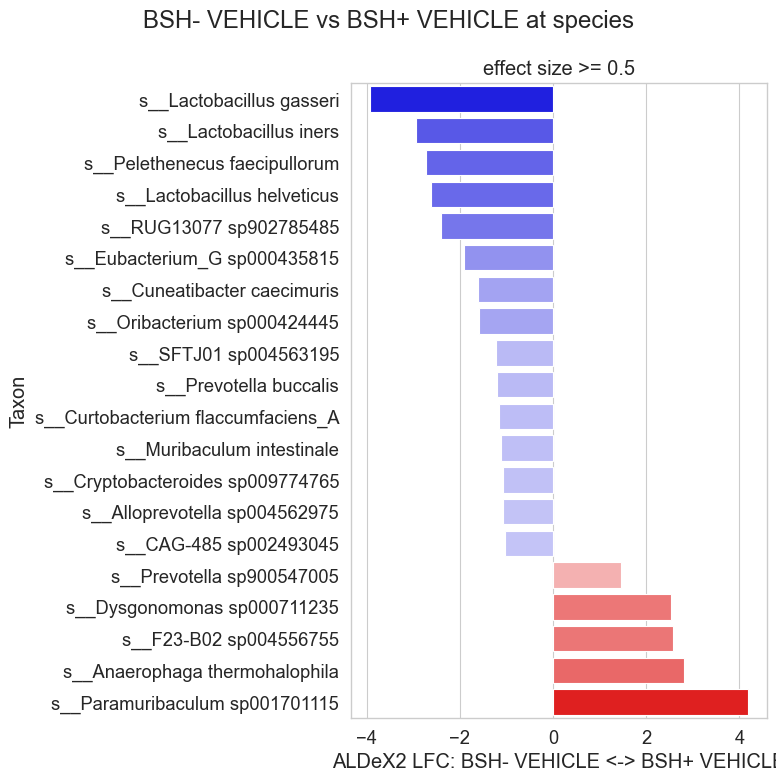

0
species: BSH- VEHICLE, BSH- LETROZOLE
66


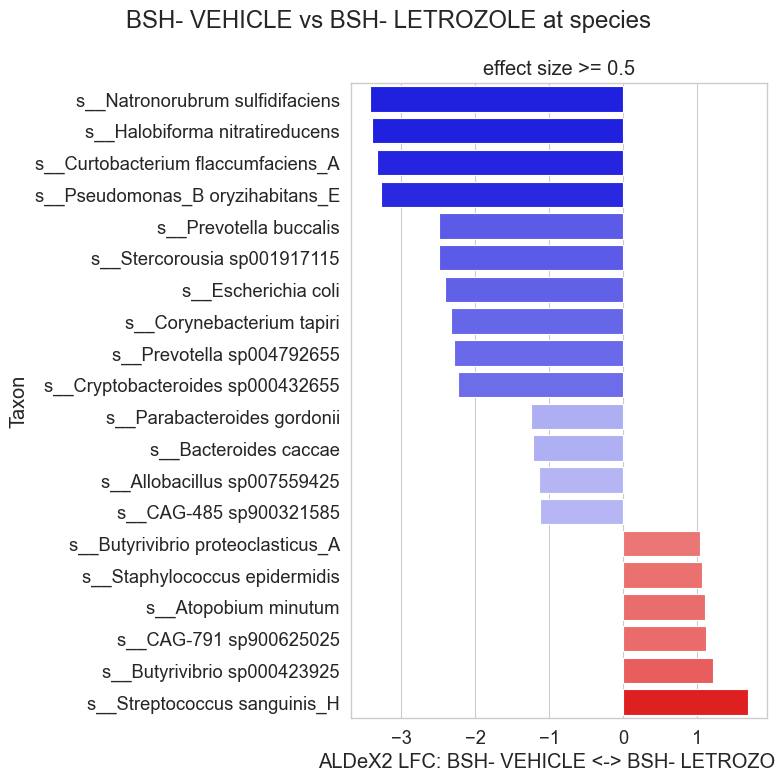

10


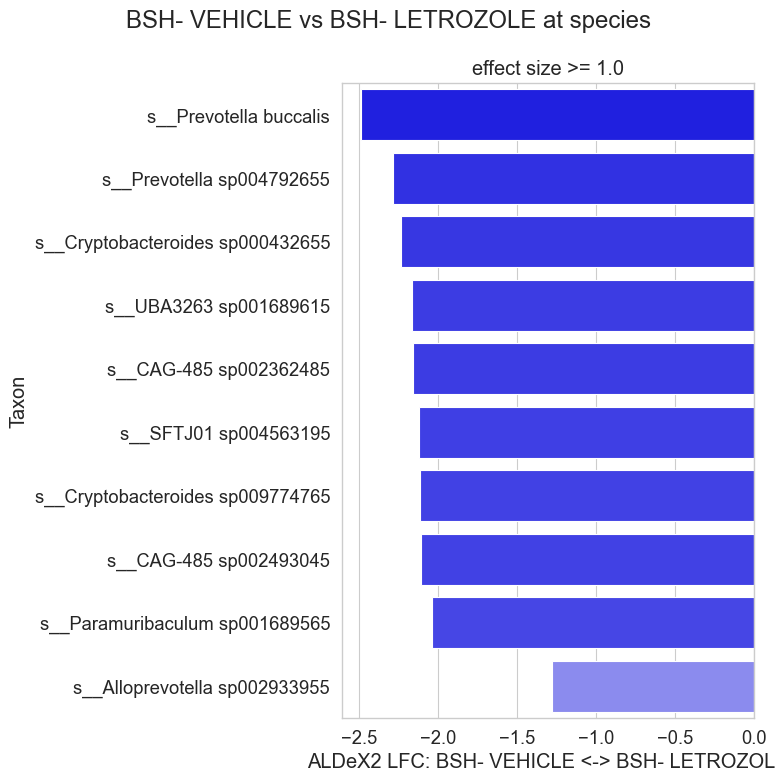

In [8]:
sig_taxa = {
    'species':set(),
}
display_orders = (
    ('BSH- VEHICLE','BSH+ VEHICLE'),
    ('BSH- VEHICLE','BSH- LETROZOLE'),
    ('BSH- VEHICLE','BSH+ LETROZOLE'),
    ('BSH+ VEHICLE','BSH- LETROZOLE'),
    ('BSH+ VEHICLE','BSH+ LETROZOLE'),
    ('BSH- LETROZOLE','BSH+ LETROZOLE'),
)
for l in lfc_tables:
    (level,compl,compr)= l.stem.split('.', maxsplit=2)
    lfc = pd.read_csv(l)
    id_col = lfc.columns[0]
    lfc['taxonomy'] = lfc[id_col].str.replace(r'^.*; ',r'', regex=True)
    lfc = lfc[~lfc.taxonomy.str.endswith('__')]  # drop unassigned
    sub_lfc = lfc.set_index('taxonomy', verify_integrity=True)
    left = lfc.columns[2][8:]
    right = lfc.columns[3][8:]
    if (left, right) not in display_orders:
        left, right = right, left
        sub_lfc['diff.btw'] = -sub_lfc['diff.btw']
    print(f'{level}: {left}, {right}')
    for q_value in (0.5, 1.0):
        significant_lfc = sub_lfc[(sub_lfc['effect'].abs() >= q_value ) & (sub_lfc['diff.btw'].abs() >= 1)].sort_values('diff.btw')
        print(len(significant_lfc))
        if len(significant_lfc)>0:
            fig, ax = plt.subplots(figsize=(8,8))
            ax = diff_plot(data=significant_lfc, x='diff.btw')
            plt.suptitle(f'{left} vs {right} at {level}')
            plt.title(f'effect size >= {q_value}')
            ax.set_xlabel(f'ALDeX2 LFC: {left} <-> {right}')
            ax.set_ylabel('Taxon')
            plt.tight_layout()
            plt.savefig(f'images/aldex2.{level}.{left}v{right}.q{q_value}.svg')
            plt.show()
            if q_value == 1.0:
                sig_taxa['species'].update(list(significant_lfc[id_col]))
